# Wine market study

## Context and client's needs
The client, Domaine des Croix, is looking to define the price of its wine bottles for the US market. They have retrieved a set of 130k bottles of wine, with grape varieties, countries and regions of production, vintages (i.e. years of production), as well as notes ('points') and descriptions from oenologists (wine specialists), and the price of all these bottles on the American market.

**The objective will be to make a presentation of the market analysis and the price you recommend for the client's wines.** The client is not a data analyst, but would like to understand the process. You will have to explain how the prices were set, without getting too technical, in other words: make it easy to understand.

#### Data sets:
- [Dataset American wine market](https://github.com/murpi/wilddata/raw/master/wine.zip)
- [Dataset American wine market](https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv)

## Market analysis: KPI
- By country:
  - Distribution of number of wines per country (all)
  - Distribution of number of wines per country (top producers)
  - Top producer countries ranked by score  

- By variety:
  - Total amount of wines produced by grape varieties (most produced)
  - Median score by grape variety (most produced)
  - Median price by grape variety (most produced)


- Time series:
  - Number of wines produced by year (top 10 most produced grape varieties)

- Pinot Noir variety:
  - Pinot Noir titles by price
  - Countries producing the most Pinot noir titles
  - Main Pinot Noir wineries
  - Number of Pinot Noir titles produced by year and country

- Descriptions
  - What words stand out the most in the wine descriptions? And specifically for Pinot Noir, is it very different?  What about the Burgundi province in France?

## Business Intelligence
### Comparative analysis
The objective here will be to compare each of the client's wines to its competitors on the market. For example, compare the prices for French wines, then more and more precisely, Burgundy wines since our client is in Burgundy, then Burgundy Pinot Noir of the same year. Do not hesitate to be original in the presentation and the dataviz used. Use all the Business Intelligence functionalities in a dashboard to help the client to compare himself (tooltips, filters, etc...).

### Value proposition
With the dashboard you provided, the customer has a clear idea of his competitors. Make him a price proposal according to his positioning (for example: 'if you want to position yourself on the top of the range, the 25% most expensive of your competitors are at this price, we advise you to align yourself with this price').

#  Data preparation and EDA

### Libraries imports, installs, settings and downloads 

In [ ]:
# Installs
%pip install geopandas
%pip install folium  
%pip install plotly==5.11.0
%pip install plotly.express
%pip install pycountry
%pip install squarify
%pip install spacy
%pip install wordcloud
%pip install colorspacious


In [361]:
# Imports
import pandas as pd
import numpy as np
import math   
import matplotlib.pyplot as plt

import seaborn as sns
import squarify 
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.offline as po
import plotly.graph_objs as pg
import plotly.graph_objects as go
import plotly.io as pio

import pycountry

import re

import datetime

import nltk
import spacy
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from colorspacious import cspace_converter

In [362]:
# Settings
# pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)

In [ ]:
# Downloads
nltk.download('popular')
nltk.download('punkt')

In [364]:
# Plotly theme
pio.templates.default = "plotly_white"

# Colors
# colors_uniform = 'Mint'
colors_monochromatic = px.colors.sequential.Reds
colors_monochromatic_reverse = px.colors.sequential.Reds_r

In [365]:
# Export data sets
# Cats

## Original ds (processed)
# df_domaine.to_csv("df_domaine.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)

## Distribution of number of wines per country
# df_global_calc.to_csv("df_global_calc.csv", index=False)
# df_producers_outliers_lower.to_csv("df_producers_outliers_lower.csv", index=False)
# df_producers_outliers_upper.to_csv("df_producers_outliers_upper.csv", index=False)
# df_producers_q0_q1.to_csv("df_producers_q0_q1.csv", index=False)
# df_producers_q1_q2.to_csv("df_producers_q1_q2.csv", index=False)
# df_producers_q2_q3.to_csv("df_producers_q2_q3.csv", index=False)
# df_producers_q3_q4.to_csv("df_producers_q3_q4.csv", index=False)

# df_producers_q3_to_max.to_csv("df_producers_q3_to_max.csv", index=False)

## Top producer countries ranked by score (proposed) = VIZ Countries with the best sores
# df_best_scores.to_csv("df_best_scores.csv", index=False)

# Average score and price by grape variety, top 10 producers
# df_grape_variety_10.to_csv("df_grape_variety_10.csv", index=False)

# df_global.to_csv("df_global.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)
# df_global.to_csv("df_global.csv", index=False)

### Datasets imports

In [366]:
# Datasets
link_global = 'https://github.com/murpi/wilddata/raw/master/wine.zip' # Dataset of 130k wines
link_domaine = 'https://github.com/murpi/wilddata/raw/master/domaine_des_croix.csv' # Dataset of the 14 Domaine des Croix wines

df_global_raw = pd.read_csv(link_global)
df_domaine_raw = pd.read_csv(link_domaine)

In [367]:
# Fast reset of df, even with my slow internet connection
df_global = df_global_raw.copy()
df_domaine = df_domaine_raw.copy()

### Reusable functions

In [368]:
# Check for percentage of missing values in full df
def missing_values(my_df):
  percent_missing = my_df.isnull().sum() * 100 / len(my_df)
  percent_missing_df = pd.DataFrame({'column': percent_missing.index, 'percent_missing': percent_missing.values})
  return percent_missing_df

In [369]:
# Drops null rows from df when the column of interest has less than 7% of null values

# Example col focus:
# cols_focus = ['country', 'points', 'price', 'year'] 

def drop_null_rows(my_df, cols_focus):
    null_counts = my_df[cols_focus].isnull().sum()
    null_threshold = my_df.shape[0] * 0.07
    columns_to_drop = null_counts[null_counts < null_threshold].index
    my_df = my_df.dropna(subset=columns_to_drop, axis=0)
    return my_df

In [370]:
# Define function that takes a dataframe, a column name, and a mathematical operation as arguments
# and returns the dataframe with an additional column:
# CATS

# def add_col(my_df, col_group, col_agg_1, col_agg_2, aggregation_1, aggregation_2):
#       new_col_1 = col_agg_1 + '_' + aggregation_1
#   new_col_2 = col_agg_2 + '_' + aggregation_2

#   df_extended = (my_df.groupby(col_group)[[col_agg_1, col_agg_2]].agg({col_agg_1:aggregation_1, col_agg_2:aggregation_2 })
#                             .reset_index()
#                             .rename(columns={col_agg_1: new_col_1, col_agg_2: new_col_2})
#                             )
#   return df_extended

# # Example:
# result = add_col(df_global, 'country','points', 'variety', 'mean', 'count').sort_values(by=['variety_count'], ascending=False)

# display(result.head(3))

In [371]:
# Define function that takes a dataframe, three column names, and three mathematical operations as arguments
# and returns the dataframe with three additional columns

def add_col(my_df, col_group, col_agg_1, col_agg_2, col_agg_3, aggregation_1, aggregation_2, aggregation_3):
  new_col_1 = col_agg_1 + '_' + aggregation_1
  new_col_2 = col_agg_2 + '_' + aggregation_2
  new_col_3 = col_agg_3 + '_' + aggregation_3

  df_extended = (my_df.groupby(col_group)[[col_agg_1, col_agg_2, col_agg_3]].agg({col_agg_1:aggregation_1, col_agg_2:aggregation_2, col_agg_3:aggregation_3})
                            .reset_index()
                            .rename(columns={col_agg_1: new_col_1, col_agg_2: new_col_2, col_agg_3: new_col_3})
                            )
  return df_extended

# Example:
result = add_col(df_global, 'country','points', 'price', 'variety','mean', 'mean', 'count').sort_values(by=['variety_count'], ascending=False)

display(result.head(3))

,country,points_mean,price_mean,variety_count
40,US,88.563720,36.166295,54504
15,France,88.842520,41.524233,22079
22,Italy,88.562231,41.759607,19540


In [372]:
# Word frequency function

# import nltk
# import string
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
punctuations = list(string.punctuation)

def analize_descriptions(my_df, my_col, n):
  # concatenate all descriptions into a single string
  all_descriptions = " ".join(my_df[my_col].tolist())

  # remove punctuations
  words = [word for word in word_tokenize(all_descriptions) if word.lower() not in punctuations]

  # remove stop words
  filtered_words = [word for word in words if word.lower() not in stop_words]

  # count the frequency of each word in the list
  word_frequency = {}
  for word in filtered_words:
      if word in word_frequency:
          word_frequency[word] += 1
      else:
          word_frequency[word] = 1

  # sort the word frequency count in descending order
  sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

  # the most frequent words will be the first items in the sorted list
  most_frequent_words = sorted_word_frequency[:n] # where n is the number of words you want to retrieve
  return most_frequent_words


### Datasets prepping

#### df_domaine

In [373]:
df_domaine.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
11,France,Made from fruit sourced from a small premier c...,Pertuisots Premier Cru,92,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2014 Pertuisots Premier Cru ...,Pinot Noir,Domaine des Croix
9,France,"A fine, mineral, structured wine with a very d...",Bressandes Premier Cru,94,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2019 Bressandes Premier Cru ...,Pinot Noir,Domaine des Croix
2,France,"A perfumed village wine, this is made from fou...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2016 Beaune,Pinot Noir,Domaine des Croix
12,France,"A dry, mineral wine, hiding its potential rich...",NaN,95,NaN,Burgundy,Corton-Charlemagne,NaN,Roger Voss,@vossroger,Domaine des Croix 2014 Corton-Charlemagne,Chardonnay,Domaine des Croix
4,France,This wine is perfumed with cherries and red be...,Les Grèves Premier Cru,94,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2017 Les Grèves Premier Cru ...,Pinot Noir,Domaine des Croix


In [374]:
# Creation of col year
# The 'title' column contains the domain, the vintage and the variety. Let'st isolate the vintage (year) in a dedicated column

def extract_years_1(string):
    years = re.findall(r'\b\d{4}\b', string)
    if years:
        years = [int(year) for year in years]
        return int(years[0])
    return np.nan

# Apply the function to each element in the 'title' column
df_domaine['year'] = df_domaine['title'].apply(extract_years_1)

In [375]:
# Set time span of analysis
max_year_domain = df_domaine['year'].max()
min_year_domain = df_domaine['year'].min()

In [376]:
# Calculate missing values
missing_values_domaine = missing_values(df_domaine)
display(missing_values_domaine)

,column,percent_missing
0,country,0.000000
1,description,0.000000
2,designation,35.714286
3,points,0.000000
4,price,100.000000
5,province,0.000000
6,region_1,0.000000
7,region_2,100.000000
8,taster_name,0.000000
9,taster_twitter_handle,0.000000


In [377]:
df_domaine.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
11,France,Made from fruit sourced from a small premier c...,Pertuisots Premier Cru,92,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2014 Pertuisots Premier Cru ...,Pinot Noir,Domaine des Croix,2014
5,France,"A structured wine, packed with red fruits and ...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2015 Beaune,Pinot Noir,Domaine des Croix,2015
3,France,"A structured wine, packed with red fruits and ...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2019 Beaune,Pinot Noir,Domaine des Croix,2019
7,France,This wine has a smoky character that gives an ...,Grèves,95,NaN,Burgundy,Corton,NaN,Roger Voss,@vossroger,Domaine des Croix 2016 Grèves (Corton),Pinot Noir,Domaine des Croix,2016
1,France,A rich wine with great fruits as well as struc...,La Vigne au Saint,94,NaN,Burgundy,Corton,NaN,Roger Voss,@vossroger,Domaine des Croix 2017 La Vigne au Saint (Cor...,Pinot Noir,Domaine des Croix,2017


#### df_global

In [378]:
df_global.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
124791,Spain,"In the small, mountainous region of Somontano,...",Finca Santa Sabina,88,27.0,Northern Spain,Somontano,NaN,Michael Schachner,@wineschach,Bodega Otto Bestué 2015 Finca Santa Sabina Cab...,Cabernet Sauvignon-Tempranillo,Bodega Otto Bestué
33782,US,"Many are now playing with the low-alcohol, ner...",NaN,94,39.0,California,Sta. Rita Hills,Central Coast,Matt Kettmann,@mattkettmann,Barden 2021 Chardonnay (Sta. Rita Hills),Chardonnay,Barden
30874,US,"This is a simple, one-dimensional Chardonnay. ...",NaN,82,10.0,California,California,California Other,NaN,NaN,Carmenet 2017 Chardonnay (California),Chardonnay,Carmenet
50121,Italy,"Luminous and bright, this well-priced Pinot Gr...",NaN,84,15.0,Northeastern Italy,Friuli Isonzo,NaN,NaN,NaN,Blason 2013 Pinot Grigio (Friuli Isonzo),Pinot Grigio,Blason
66863,France,"This ripe, balanced and mature wine is ready t...",Le Nombre d'Or Brut,92,104.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Aubry NV Le Nombre d'Or Brut (Champagne),Champagne Blend,Aubry


In [379]:
# Creation of col year and a control column
# to be made in several steps due to the fact that some 'title' lines contain several number
# Function to extract all years (4-digit format)
def extract_years(string):
    years = re.findall(r'\b\d{4}\b', string)
    if years:
        years = [int(year) for year in years]
        return years
    return np.nan

# Apply the function to each element in the 'title' column and on the 'winery' column, for control
df_global['year'] = df_global['title'].apply(extract_years)
df_global['year_cotrol'] = df_global['winery'].apply(extract_years)

In [380]:
# Let's take a look at the 'year' lines containing more than a number 
control = df_global[df_global['year_cotrol'].notna()]
control.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,year_cotrol
128803,Italy,This simple sparkler from Campania opens with ...,Pas Dosé,85,18.0,Southern Italy,Fiano di Avellino,NaN,Kerin O’Keefe,@kerinokeefe,Tenuta Sarno 1862 2019 Pas Dosé (Fiano di Ave...,Fiano,Tenuta Sarno 1860,"[1862, 2019]",[1860]
20841,US,Intensely mineral on the nose with aromas of w...,Homestead Reserve,89,27.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Hazlitt 1854 Vineyards 2016 Homestead Reserve ...,Riesling,Hazlitt 1852 Vineyards,"[1854, 2016]",[1852]
68579,US,"A new effort from winemaker Isabelle Dutartre,...",NaN,91,58.0,Oregon,Chehalem Mountains,Willamette Valley,Paul Gregutt,@paulgwine,1791 Wines 2011 Pinot Noir (Chehalem Mountains),Pinot Noir,1789 Wines,"[1791, 2011]",[1789]
35791,Italy,"Aromas of cedar, grilled pepper, cut grass and...",NaN,90,34.0,Tuscany,Bolgheri,NaN,Kerin O’Keefe,@kerinokeefe,Donna Olimpia 1900 2016 Bolgheri,Red Blend,Donna Olimpia 1898,"[1900, 2016]",[1898]
114912,Italy,"A blend of 80% Carricante and 20% Catarratto, ...",Pietralava Bianco,88,26.0,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Antichi Vinai 1879 2016 Pietralava Bianco (Etna),White Blend,Antichi Vinai 1877,"[1879, 2016]",[1877]


In [381]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129957 entries, 0 to 129956
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129894 non-null  object 
 1   description            129957 non-null  object 
 2   designation            92497 non-null   object 
 3   points                 129957 non-null  int64  
 4   price                  120964 non-null  float64
 5   province               129894 non-null  object 
 6   region_1               108710 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103713 non-null  object 
 9   taster_twitter_handle  98744 non-null   object 
 10  title                  129957 non-null  object 
 11  variety                129956 non-null  object 
 12  winery                 129957 non-null  object 
 13  year                   125348 non-null  object 
 14  year_cotrol            161 non-null 

In [382]:
 # Calculate missing values
missing_values_global = missing_values(df_global)

display(missing_values_global)

,column,percent_missing
0,country,0.048478
1,description,0.000000
2,designation,28.824919
3,points,0.000000
4,price,6.919981
5,province,0.048478
6,region_1,16.349254
7,region_2,61.132528
8,taster_name,20.194372
9,taster_twitter_handle,24.017944


In [383]:
# Drops null rows from df_global when the column of interest has less than 7% of null values
cols_focus = ['country', 'points', 'price', 'year'] 

df_global = drop_null_rows(df_global, cols_focus)

In [384]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116768 entries, 1 to 129956
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                116768 non-null  object 
 1   description            116768 non-null  object 
 2   designation            82297 non-null   object 
 3   points                 116768 non-null  int64  
 4   price                  116768 non-null  float64
 5   province               116768 non-null  object 
 6   region_1               97704 non-null   object 
 7   region_2               49540 non-null   object 
 8   taster_name            93203 non-null   object 
 9   taster_twitter_handle  88386 non-null   object 
 10  title                  116768 non-null  object 
 11  variety                116767 non-null  object 
 12  winery                 116768 non-null  object 
 13  year                   116768 non-null  object 
 14  year_cotrol            142 non-null 

In [385]:
# extract values between min_year and max_year 

# # To do: fix this ugly harcoded years
# # Following code sends error: TypeError: '<=' not supported between instances of 'int' and 'str'
# df_global['year'] = df_global['year'].apply(lambda x: [y for y in x if min_year <= y <= max_year_domain])

# Max year =  2023
# Min year =  2009

df_global['year'] = df_global['year'].apply(lambda x: [y for y in x if 2009 <= y <= 2023])

# Keep only the biggest year
def extract_max(row):
    if len(row) > 0:
        return max(row)
    else:
        return np.nan

df_global['year'] = df_global['year'].apply(extract_max)



In [386]:
control_2 = df_global[df_global['year_cotrol'].notna()]
control_2.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,year_cotrol
2262,Italy,One of Italy's most interesting and least-know...,Canua,87,57.0,Lombardy,Valtellina Superiore,NaN,NaN,NaN,Salis 1639 2006 Canua (Valtellina Superiore),Nebbiolo,Salis 1637,NaN,[1637]
3929,Argentina,"Sharp, prickly aromas suggest tart red plum an...",1492,83,9.0,Mendoza Province,Mendoza,NaN,Michael Schachner,@wineschach,Don Cristobal 1494 2014 1494 Red (Mendoza),Red Blend,Don Cristobal 1492,2014.0,[1492]
4555,Spain,"This reedy, strained Garnacha features cheesy ...",Ramón Roqueta,81,10.0,Catalonia,Catalunya,NaN,Michael Schachner,@wineschach,Bodegas 1900 2013 Ramón Roqueta Garnacha (Cata...,Garnacha,Bodegas 1898,2013.0,[1898]
5346,US,Tighter blackberry and blueberry fruits meet w...,7200,89,34.0,California,Happy Canyon of Santa Barbara,Central Coast,Matt Kettmann,@mattkettmann,Foxen 7202 2016 7202 Cabernet Sauvignon (Happy...,Cabernet Sauvignon,Foxen 7200,2016.0,[7200]
5364,US,"Green melon, lime and lemon flavors ring fresh...",Unoaked,89,22.0,New York,Finger Lakes,Finger Lakes,Anna Lee C. Iijima,NaN,Hazlitt 1854 Vineyards 2017 Unoaked Chardonnay...,Chardonnay,Hazlitt 1852 Vineyards,2017.0,[1852]


In [387]:
# Drop null values
cols_focus = ['year'] 

df_global = drop_null_rows(df_global, cols_focus)

# Correct data type
df_global['year'] = df_global['year'].astype(int)

# Drop 'year_cotrol'
df_global = df_global.drop(columns=['year_cotrol'])

#### Let's check on the dinal df

In [388]:
df_global.head(3)


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,20.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2017 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2017
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,18.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2019 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2019
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,18.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2019 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2019


In [389]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113346 entries, 1 to 129956
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                113346 non-null  object 
 1   description            113346 non-null  object 
 2   designation            80067 non-null   object 
 3   points                 113346 non-null  int64  
 4   price                  113346 non-null  float64
 5   province               113346 non-null  object 
 6   region_1               94884 non-null   object 
 7   region_2               48072 non-null   object 
 8   taster_name            91508 non-null   object 
 9   taster_twitter_handle  86707 non-null   object 
 10  title                  113346 non-null  object 
 11  variety                113346 non-null  object 
 12  winery                 113346 non-null  object 
 13  year                   113346 non-null  int64  
dtypes: float64(1), int64(2), object(11)


In [390]:
# Descriptive statistics
df_global[['points', 'price', 'year']].describe()

,points,price,year
count,113346.000000,113346.000000,113346.000000
mean,88.479514,34.888210,2017.084008
std,3.030017,28.988085,3.002580
min,80.000000,2.000000,2009.000000
25%,86.000000,21.000000,2015.000000
50%,88.000000,29.000000,2018.000000
75%,91.000000,41.000000,2019.000000
max,100.000000,1902.000000,2023.000000


In [391]:
df_domaine.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
0,France,Firm and solid with great swathes of black fru...,NaN,94,NaN,Burgundy,Corton Grèves,NaN,Roger Voss,@vossroger,Domaine des Croix 2016 Corton Grèves,Pinot Noir,Domaine des Croix,2016
1,France,A rich wine with great fruits as well as struc...,La Vigne au Saint,94,NaN,Burgundy,Corton,NaN,Roger Voss,@vossroger,Domaine des Croix 2017 La Vigne au Saint (Cor...,Pinot Noir,Domaine des Croix,2017
2,France,"A perfumed village wine, this is made from fou...",NaN,90,NaN,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Domaine des Croix 2016 Beaune,Pinot Noir,Domaine des Croix,2016


In [392]:
df_domaine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                14 non-null     object 
 1   description            14 non-null     object 
 2   designation            9 non-null      object 
 3   points                 14 non-null     int64  
 4   price                  0 non-null      float64
 5   province               14 non-null     object 
 6   region_1               14 non-null     object 
 7   region_2               0 non-null      float64
 8   taster_name            14 non-null     object 
 9   taster_twitter_handle  14 non-null     object 
 10  title                  14 non-null     object 
 11  variety                14 non-null     object 
 12  winery                 14 non-null     object 
 13  year                   14 non-null     int64  
dtypes: float64(2), int64(2), object(10)
memory usage: 1.7+ KB


In [393]:
# Descriptive statistics
df_domaine[['points', 'price', 'year']].describe()

,points,price,year
count,14.000000,0.0,14.000000
mean,92.928571,NaN,2016.785714
std,1.859044,NaN,1.672335
min,90.000000,NaN,2014.000000
25%,92.000000,NaN,2016.000000
50%,93.500000,NaN,2017.000000
75%,94.000000,NaN,2018.000000
max,95.000000,NaN,2019.000000


# Market analysis: KPI

## KPI by country

### Distribution of number of wines per country

In [394]:
# Create df counting nb of wines per country
df_global_calc = (add_col(df_global, 'country','points', 'price','variety', 'mean', 'mean', 'count')
                          .rename(columns={'variety_count': 'nb_of_wines'})
                          .sort_values(by=['nb_of_wines'], ascending=False)
                          )

# Number of wines per country distribution by decil
df_global_calc['decile_rank_by_nb_of_wines'] = pd.qcut(df_global_calc['nb_of_wines'], 10,labels = False)

# df_global_calc = add_col(df_global, 'country','title', 'count').rename(columns={'title_count': 'nb_of_wines'})
df_global_calc.head()

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
39,US,88.629409,35.603927,51801,9
14,France,88.717300,36.277018,16017,9
21,Italy,88.730814,41.110186,15610,9
36,Spain,87.340390,30.757494,5905,9
30,Portugal,88.290626,26.584976,4566,9


In [395]:
df_global_calc['nb_of_wines'].describe()

count       42.000000
mean      2698.714286
std       8530.440461
min          1.000000
25%         12.000000
50%         79.500000
75%       1259.000000
max      51801.000000
Name: nb_of_wines, dtype: float64

In [396]:
# Visualize outliers
fig_out = px.box(df_global_calc,
                y='nb_of_wines',
                # color_continuous_scale=colors_monochromatic, # Fix this: set colour according to the palette
                )
fig_out.show()

In [397]:
# Divide df_global_calc acording to quartiles by nb_of_wines produced
# Quartiles
q1 = df_global_calc['nb_of_wines'].quantile(0.25)
q2 = df_global_calc['nb_of_wines'].quantile(0.5)
q3 = df_global_calc['nb_of_wines'].quantile(0.75)

iqr = q3 - q1
q0 = q1 - 1.5 * iqr
q4 = q3 + 1.5 * iqr

# # Df by quantiles
df_producers_q0_q1 = df_global_calc[df_global_calc['nb_of_wines'].between(q0, q1, inclusive='left')]
df_producers_q1_q2 = df_global_calc[df_global_calc['nb_of_wines'].between(q1, q2, inclusive='left')]
df_producers_q2_q3 = df_global_calc[df_global_calc['nb_of_wines'].between(q2, q3, inclusive='left')]
df_producers_q3_q4 = df_global_calc[df_global_calc['nb_of_wines'].between(q3, q4, inclusive='left')]

df_producers_outliers_lower = df_global_calc[df_global_calc['nb_of_wines'] <= q0]
df_producers_outliers_upper = df_global_calc[df_global_calc['nb_of_wines'] >= q4]

df_producers_q3_to_max = df_global_calc[df_global_calc['nb_of_wines'] >= q3]


In [398]:
# Check if df_global_calc is divided correctly
test = len(df_global_calc) == len(df_producers_q0_q1) + len(df_producers_q1_q2) + len(df_producers_q2_q3) + len(df_producers_q3_q4) + len(df_producers_outliers_lower) + len(df_producers_outliers_upper)
test

True

In [399]:
df_producers_outliers_upper

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines
39,US,88.629409,35.603927,51801,9
14,France,88.717300,36.277018,16017,9
21,Italy,88.730814,41.110186,15610,9
36,Spain,87.340390,30.757494,5905,9
30,Portugal,88.290626,26.584976,4566,9
8,Chile,86.586048,23.562956,4114,8
0,Argentina,86.742031,25.934090,3702,8


In [400]:
# VIZ distribution of the number of wines per country
def viz_distribution_country(my_df, my_title):
    fig = px.bar(my_df,
    x='country',
    y='nb_of_wines',
    color='country',
    text_auto=True,
    title='Distribution of the number of wines per country ' + my_title,
    height=700,
    # orientation='h'
    color_discrete_sequence=colors_monochromatic_reverse,
    labels={
        "country": "Country",
        "nb_of_wines": "Number of wines",
        "country": "Country"
    }
    )

    fig.update_traces(textfont_size=12, 
                      textangle=0, 
                      textposition='outside', 
                      cliponaxis=False)

    return  fig.show()

# Titles
title_all = '(all)'
title_q0_q1 = '(Q0 - Q1)'
title_q1_q2 = '(Q1 - Q2)'
title_q2_q3 = '(Q2 - Q3)'
title_q3_q4 = '(Q3 - Q4)'
title_upper = '(upper outliers)'
title_q3_to_max = '(Q3 and up)'

# list_df_producers = [df_global_calc, df_producers_q0_q1, df_producers_q1_q2, df_producers_q2_q3, df_producers_q3_q4, df_producers_outliers_upper, df_producers_q3_to_max]
# list_titles = [title_all, title_q0_q1, title_q1_q2, title_q2_q3, title_q3_q4, title_upper, title_q3_to_max]

list_df_producers = [df_global_calc, df_producers_q3_to_max]
list_titles = [title_all, title_q3_to_max]

for i, j in zip(list_df_producers, list_titles):
  viz_distribution_country(i, j)

### Top producer countries ranked by score


In [401]:
# Top producer countries ranked by score
df_best_scores = df_producers_q3_to_max.sort_values(by=['nb_of_wines'], ascending=False)

# Extract alpha_3 to be able to make the viz
# For some reaspn usa misbihaves, that's why the df is sliced like [1:] and then the alpha_3 is set manually I set it manually
df_best_scores['alpha_2'] = df_best_scores['country'][1:].apply(lambda x: pycountry.countries.get(name=x).alpha_3)
df_best_scores.iloc[0, 5] = 'USA' 

min_score = min(df_best_scores['points_mean'])
max_score = max(df_best_scores['points_mean'])

df_best_scores = df_best_scores.sort_values(by=['points_mean'], ascending=False)
df_best_scores

,country,points_mean,price_mean,nb_of_wines,decile_rank_by_nb_of_wines,alpha_2
3,Austria,90.228019,32.629697,2741,8,AUT
16,Germany,89.839141,39.497852,2095,8,DEU
2,Australia,88.817221,38.859013,1986,7,AUS
21,Italy,88.730814,41.110186,15610,9,ITA
14,France,88.717300,36.277018,16017,9,FRA
39,US,88.629409,35.603927,51801,9,USA
28,New Zealand,88.383476,29.243180,1283,7,NZL
30,Portugal,88.290626,26.584976,4566,9,PRT
36,Spain,87.340390,30.757494,5905,9,ESP
0,Argentina,86.742031,25.934090,3702,8,ARG


In [402]:
# VIZ Countries with the best sores
fig_top_10 = px.choropleth(df_best_scores,
                    locations='alpha_2',
                    color='points_mean',
                    hover_name='country', # column to add to hover information
                    hover_data=['points_mean', 'nb_of_wines', 'price_mean'],
                    range_color=(min_score, max_score),
                    color_continuous_scale=colors_monochromatic_reverse,

                    )


fig_top_10.update_layout(
    title_text='Top producer countries ranked by score',
    coloraxis_colorbar_title = 'points',    
    height=700, # Map height
)

fig_top_10.update_geos(showframe=False,
                showcoastlines=False,
                # coastlinecolor='RebeccaPurple',
                showland=True, 
                landcolor='LightGrey',
                projection_type='equirectangular',
                # lataxis_showgrid=True,
                # lonaxis_showgrid=True
)

fig_top_10.update_traces(marker_line_color='white',
                  marker_line_width=0.5
                  )


fig_top_10.show()

## KPI by variety

### Median score, price and total number of wines produced by grape variety


In [403]:
unique_varieties = len(df_global['variety'].unique())
print('There are ', unique_varieties, 'unique varieties')

There are  668 unique varieties


In [404]:
# Average score and price by grape variety, top 10 varietiies
df_grape_variety = (add_col(df_global, 'variety','points', 'price', 'year','median', 'median', 'count')
                        .rename(columns={"year_count": "nb_of_wines"})
                        .sort_values(by=['nb_of_wines'], ascending=False))

# Average score and price by grape variety distribution by decil
df_grape_variety['decile_rank_by_nb_of_wines_produced'] = pd.qcut(df_grape_variety['nb_of_wines'], 10,labels = False, duplicates='drop')

df_grape_variety_10 = df_grape_variety[:9].copy()

df_grape_variety_10.head(3)

,variety,points_median,price_median,nb_of_wines,decile_rank_by_nb_of_wines_produced
421,Pinot Noir,90.0,39.0,12342,7
120,Chardonnay,88.0,28.0,10324,7
76,Cabernet Sauvignon,88.0,37.0,8998,7


In [405]:
# Number of wines produced by grape variety
fig = px.bar(df_grape_variety_10,
            x= 'nb_of_wines',
            y= 'variety',
            color= 'variety',
            text_auto=True,
            title = 'Total amount of wines produced by grape varieties (most produced)',
            height=700,
            orientation='h',
            color_discrete_sequence=colors_monochromatic_reverse,
            labels={
                "variety": "Variety",
                "nb_of_wines": "Number of wines",
            }
            )

fig.update_traces(textfont_size=12, 
                    textangle=0, 
                    textposition='outside', 
                    cliponaxis=False)

fig.show()


In [406]:
# Average price by grape variety
# avg_price = viz_distribution_vertical(df_grape_variety_10, title_price, 'price_mean', 'variety', 'variety')

# Number of wines produced by grape variety
fig = px.bar(df_grape_variety_10,
            y= 'price_median',
            x= 'variety',
            color= 'variety',
            text_auto=True,
            title = 'Median price by grape variety (most produced)',
            height=700,
            orientation='v',
            color_discrete_sequence=colors_monochromatic_reverse,
            labels={
                "variety": "Variety",
                "price_mean": "Price mean",
            }
            )

fig.update_traces(textfont_size=12, 
                    textangle=0, 
                    textposition='outside', 
                    cliponaxis=False)

fig.show()


In [407]:
# Average score by grape variety
fig = px.bar(df_grape_variety_10,
            y= 'points_median',
            x= 'variety',
            color= 'variety',
            text_auto=True,
            title = 'Median score by grape variety (most produced)',
            height=700,
            orientation='v',
            color_discrete_sequence=colors_monochromatic_reverse,
            labels={
                "variety": "Variety",
                "price_mean": "Price mean",
            }
            )

fig.update_traces(textfont_size=12, 
                    textangle=0, 
                    textposition='outside', 
                    cliponaxis=False)

fig.show()

### Top ranked grape varieties, from most produced wines

In [408]:
# # Divide df_grape_variety acording to quartiles by nb_of_wines produced
# # Quartiles
q1 = df_grape_variety['nb_of_wines'].quantile(0.25)
q2 = df_grape_variety['nb_of_wines'].quantile(0.5)
q3 = df_grape_variety['nb_of_wines'].quantile(0.75)

iqr = q3 - q1
q0 = q1 - 1.5 * iqr
q4 = q3 + 1.5 * iqr

# # Df by quantiles
df_varieties_q0_q1 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q0, q1, inclusive='left')]
df_varieties_q1_q2 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q1, q2, inclusive='left')]
df_varieties_q2_q3 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q2, q3, inclusive='left')]
df_varieties_q3_q4 = df_grape_variety[df_grape_variety['nb_of_wines'].between(q3, q4, inclusive='left')]

df_varieties_outliers_lower = df_grape_variety[df_grape_variety['nb_of_wines'] <= q0]
df_varieties_outliers_upper = df_grape_variety[df_grape_variety['nb_of_wines'] >= q4]

df_varieties_q3_to_max = df_grape_variety[df_grape_variety['nb_of_wines'] >= q3]

In [409]:
# Top ranked grape varieties
df_top_ranked_variety = df_varieties_q3_to_max.sort_values(by=['points_median'], ascending=False)
df_top_ranked_variety = df_top_ranked_variety[:30]
df_top_ranked_variety

,variety,points_median,price_median,nb_of_wines,decile_rank_by_nb_of_wines_produced
116,Champagne Blend,92.0,85.0,270,7
554,Tannat-Cabernet,91.0,27.0,26,5
486,Sangiovese Grosso,91.0,68.0,586,7
443,Provence red blend,91.0,28.0,59,6
430,Port,91.0,46.0,257,7
31,Austrian white blend,90.5,31.0,58,6
421,Pinot Noir,90.0,39.0,12342,7
184,Furmint,90.0,27.5,50,6
538,Syrah-Cabernet Sauvignon,90.0,38.0,37,5
652,Weissburgunder,90.0,27.0,39,6


## Time series: Number of wines produced by year (top 10 most produced grape varieties)

#### Code

In [410]:
# Most produced grape varieties
grape_varieties = df_grape_variety_10['variety'].to_list()
grape_varieties

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé']

In [411]:
df_global_yearly = df_global[df_global['variety'].isin(grape_varieties)]
df_global_yearly = df_global_yearly.groupby(['year', 'variety'])['country'].count().reset_index().rename(columns = {'country':'nb_of_wines'})

df_global_yearly.tail(20)

,year,variety,nb_of_wines
106,2021,Cabernet Sauvignon,190
107,2021,Chardonnay,1118
108,2021,Pinot Noir,970
109,2021,Red Blend,274
110,2021,Riesling,739
111,2021,Rosé,732
112,2021,Sauvignon Blanc,681
113,2021,Syrah,85
114,2022,Bordeaux-style Red Blend,23
115,2022,Cabernet Sauvignon,22


In [412]:
### Number of wines produced by year (top 10 most produced grape varieties)

fig = px.line(df_global_yearly,
              x="year",
              y="nb_of_wines",
              color='variety',
            )

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_layout(
    hovermode="x unified",
    hoverlabel = dict(namelength = -1), # Displays full text on hover unified                
    # bgcolor="white",
    font_size=16,
    # font_family="Rockwell"   
    title_text=('Number of wines produced by year (top 10 most produced grape varieties)'),
    height=600, # Map height
)



fig.show()

## Pinot Noir


### Pinot Noir titles by price

In [413]:
df_pinot = df_global[df_global['variety'] == 'Pinot Noir'].sort_values('price', ascending= False)
df_pinot.head(10)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
113554,France,"A wonderfully complete wine, with all the elem...",NaN,96,1902.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2011 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2011
98371,France,"A superb wine from a great year, this is power...",NaN,96,1590.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2016 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2016
113571,France,"While it starts austerely, this wine is obviou...",NaN,94,1008.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2012 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2012
113556,France,"Big and bold, this is real Chambertin, a dense...",NaN,96,530.0,Burgundy,Chambertin Clos de Bèze,NaN,Roger Voss,@vossroger,Bouchard Père & Fils 2012 Chambertin Clos de ...,Pinot Noir,Bouchard Père & Fils,2012
84812,France,Produced from vines mainly planted in the 1970...,NaN,95,390.0,Burgundy,Musigny,NaN,Roger Voss,@vossroger,Domaine Jacques Prieur 2020 Musigny,Pinot Noir,Domaine Jacques Prieur,2020
21712,France,"A sumptuous wine, rich in bright red fruits, w...",Musigny,96,378.0,Burgundy,Musigny,NaN,Roger Voss,@vossroger,Domaine Jacques Prieur 2015 Musigny (Musigny),Pinot Noir,Domaine Jacques Prieur,2015
113559,France,"Smoky, rich, this wine packs a powerful punch ...",NaN,95,376.0,Burgundy,Echézeaux,NaN,Roger Voss,@vossroger,Bouchard Père & Fils 2012 Echézeaux,Pinot Noir,Bouchard Père & Fils,2012
75935,France,"Despite its power, this is so elegant, showing...",Chambertin Clos de Bèze Grand Cru,96,355.0,Burgundy,Chambertin Clos de Bèze,NaN,Roger Voss,@vossroger,Domaine Perrot-Minot 2016 Chambertin Clos de B...,Pinot Noir,Domaine Perrot-Minot,2016
90899,France,"A firm and tannic wine, this has dry spices, d...",NaN,97,348.0,Burgundy,Grands-Echezeaux,NaN,Roger Voss,@vossroger,Joseph Drouhin 2018 Grands-Echezeaux,Pinot Noir,Joseph Drouhin,2018
48890,France,"A beautiful wine, smooth, polished, with round...",NaN,98,330.0,Burgundy,Clos de Tart,NaN,Roger Voss,@vossroger,Clos de Tart 2011 Clos de Tart,Pinot Noir,Clos de Tart,2011


### Countries producing the most Pinot noir titles

#### Code

In [414]:
df_pinot_country = add_col_extra(df_pinot, 'country', 'variety', 'points', 'price', 'count', 'mean', 'mean').sort_values('variety_count', ascending= False)
df_pinot_country = df_pinot_country[:9]

# # Extract alpha_3 to be able to make the viz
# For some reaspn usa misbihaves, that's why the df is sliced like [1:] and then the alpha_3 is set manually I set it manually
df_pinot_country['alpha_2'] = df_pinot_country['country'][1:].apply(lambda x: pycountry.countries.get(name=x).alpha_3)
df_pinot_country.iloc[0, 4] = 'USA' 
df_pinot_country


,country,variety_count,points_mean,price_mean,alpha_2
21,US,9580,89.665240,40.312317,USA
8,France,1449,89.840580,63.204969,FRA
14,New Zealand,475,88.376842,34.046316,NZL
5,Chile,345,85.979710,20.084058,CHL
1,Australia,121,87.504132,32.181818,AUS
0,Argentina,101,85.693069,23.158416,ARG
2,Austria,83,90.433735,38.000000,AUT
9,Germany,55,89.436364,32.690909,DEU
4,Canada,23,88.521739,30.478261,CAN


In [415]:
# VIZ Countries producing the most Pinot noir titles
min_score_pinot = min(df_pinot_country['variety_count'])
max_score_pinot = max(df_pinot_country['variety_count'])


fig_top_pinot = px.choropleth(df_pinot_country,
                    locations='alpha_2',
                    color='variety_count',
                    hover_name='country', # column to add to hover information
                    hover_data=['points_mean', 'variety_count', 'price_mean'],
                    range_color=(min_score_pinot, max_score_pinot),
                    color_continuous_scale=colors_monochromatic,
                    )


fig_top_pinot.update_layout(
    title_text='Countries producing the most Pinot noir titles',
    coloraxis_colorbar_title = 'variety count',    
    height=700, # Map height
)

fig_top_pinot.update_geos(showframe=False,
                showcoastlines=False,
                # coastlinecolor='RebeccaPurple',
                showland=True, 
                landcolor='LightGrey',
                projection_type='equirectangular',
                # lataxis_showgrid=True,
                # lonaxis_showgrid=True
)

fig_top_pinot.update_traces(marker_line_color='white',
                  marker_line_width=0.5
                  )

fig_top_pinot.show()

### Main Pinot Noir wineries by number of titles produced

In [416]:
df_pinot_winery = df_pinot.groupby(['country', 'winery'])[['title', 'points', 'price']].agg({'title':'count','points':'mean', 'price':'mean' }).reset_index().sort_values('title', ascending= False)
df_pinot_winery = df_pinot_winery[:20]
df_pinot_winery

,country,winery,title,points,price
2408,US,Williams Selyem,137,93.021898,58.510949
2133,US,Siduri,122,90.434426,40.278689
2250,US,Testarossa,116,90.827586,49.112069
457,France,Louis Latour,90,90.700000,92.522222
1713,US,Lynmar,68,92.985294,55.264706
1023,US,Calera,65,90.892308,50.430769
1397,US,Gary Farrell,61,91.590164,51.967213
1689,US,Loring Wine Company,60,90.116667,42.600000
1721,US,MacPhail,58,90.827586,48.810345
1882,US,Pali,57,89.070175,40.350877


In [417]:
# Main Pinot Noir wineries by number of titles produced
  
# viz_distribution_vertical(df_pinot_winery, 'Main Pinot Noir wineries by number of titles produced', 'winery', 'title', 'country')



# Number of wines produced by grape variety
fig = px.bar(df_pinot_winery,
            y= 'title',
            x= 'winery',
            color= 'country',
            text_auto=True,
            title = 'Main Pinot Noir wineries by number of titles produced',
            height=700,
            orientation='v',
            color_discrete_sequence=colors_monochromatic_reverse,
            labels={
                "variety": "Variety",
                "price_mean": "Price mean",
            }
            )

fig.update_traces(textfont_size=12, 
                    textangle=0, 
                    textposition='outside', 
                    cliponaxis=False)



### Number of Pinot Noir titles produced by year and country

#### Code

In [418]:
df_pinot.head(1)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
113554,France,"A wonderfully complete wine, with all the elem...",NaN,96,1902.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2011 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2011


In [419]:
df_pinot_yearly = df_pinot.groupby(['year', 'country'])['title'].count().reset_index().rename(columns = {'title':'nb_of_wines'})

df_pinot_yearly.tail(30)

,year,country,nb_of_wines
129,2020,Austria,13
130,2020,Bulgaria,2
131,2020,Canada,5
132,2020,Chile,44
133,2020,England,3
134,2020,France,343
135,2020,Germany,13
136,2020,New Zealand,52
137,2020,Portugal,1
138,2020,Romania,4


In [420]:
### Number of wines produced by year (top 10 most produced grape varieties)

fig = px.line(df_pinot_yearly,
              x="year",
              y="nb_of_wines",
              color='country',
            )

fig.update_traces(mode="markers+lines", hovertemplate=None)

fig.update_layout(
    hovermode="x unified",
    hoverlabel = dict(namelength = -1), # Displays full text on hover unified                
    # bgcolor="white",
    font_size=16,
    # font_family="Rockwell"   
    title_text=('Number of Pinot Noir titles produced by year'),
    height=600, # Map height
)

fig.show()

## Descriptions
What words stand out the most in the wine descriptions? And specifically for Pinot Noir, is it very different?  What about the Burgundi province in France?


#### Code

In [421]:
# df_pinot is huge, I'll work with a sample
df_pinot_sample = df_pinot.sample(n=3000)

# df_global is huge, I'll work with a sample
df_global_sample = df_global.sample(n=3000)

# df Burgundy
df_burgundy = df_global[df_global['province'] == 'Burgundy']

In [422]:
# Global
most_frequent_words_global = analize_descriptions(df_global_sample, 'description', 20)
df_most_frequent_words_global = pd.DataFrame(most_frequent_words_global, columns=['Word_global', 'Count_global'])

# Burgundy
most_frequent_words_burgundy = analize_descriptions(df_burgundy, 'description', 20)
df_most_frequent_words_burgundy = pd.DataFrame(most_frequent_words_burgundy, columns=['Word_burgundy', 'Count_burgundy'])

# Pinot
most_frequent_words_pinot = analize_descriptions(df_pinot_sample, 'description', 20)
df_most_frequent_words_pinot = pd.DataFrame(most_frequent_words_pinot, columns=['Word_pinot', 'Count_pinot'])

In [423]:
df_wine_descriptions = pd.concat([df_most_frequent_words_global, df_most_frequent_words_burgundy, df_most_frequent_words_pinot ], axis=1)
df_wine_descriptions

,Word_global,Count_global,Word_burgundy,Count_burgundy,Word_pinot,Count_pinot
0,wine,1848,wine,4016,wine,1799
1,flavors,1431,acidity,1771,'s,1471
2,'s,1204,ripe,1272,flavors,1408
3,fruit,1024,fruits,1267,cherry,1266
4,palate,889,fruit,1177,fruit,1148
5,finish,824,Drink,1106,Pinot,902
6,aromas,821,flavors,1017,acidity,800
7,acidity,763,tannins,820,finish,699
8,tannins,736,rich,779,tannins,686
9,cherry,686,texture,718,red,648


In [424]:
df_pinot_sample.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
19108,US,"Tart and fruity, this mixes strawberry and cit...",Estate,87,24.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Apolloni 2020 Estate Pinot Noir (Willamette Va...,Pinot Noir,Apolloni,2020
45218,US,"Lots of zingy acidity in this Pinot, but also ...",Cohn Vineyard,90,60.0,California,Sonoma County,Sonoma,NaN,NaN,Benovia 2015 Cohn Vineyard Pinot Noir (Sonoma ...,Pinot Noir,Benovia,2015
3475,US,Though the winery indicates that just one quar...,Whole Cluster Reserve,88,46.0,Oregon,Willamette Valley,NaN,Paul Gregutt,@paulgwine,Bishop Creek Cellars 2013 Whole Cluster Reserv...,Pinot Noir,Bishop Creek Cellars,2013


In [425]:
# # df_pinot is huge, I'll work with a sample
# df_pinot_sample = df_pinot.sample(n=3000)

# # df_global is huge, I'll work with a sample
# df_global_sample = df_global.sample(n=3000)

# # df Burgundy
# df_burgundy = df_global[df_global['province'] == 'Burgundy']

# Create a string of text data from the dataframe
text_pinot = " ".join(review for review in df_pinot_sample["description"])

text_global = " ".join(review for review in df_global_sample["description"])

text_burgundy = " ".join(review for review in df_burgundy["description"])


def word_cloud(my_text):
  # Generate a word cloud image
  wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110, background_color='white', colormap='Reds').generate(my_text)

  # Plot the word cloud image
  plt.figure(figsize=(10, 10), facecolor='k')
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.tight_layout(pad=0)
  plt.show()


#### VIZ

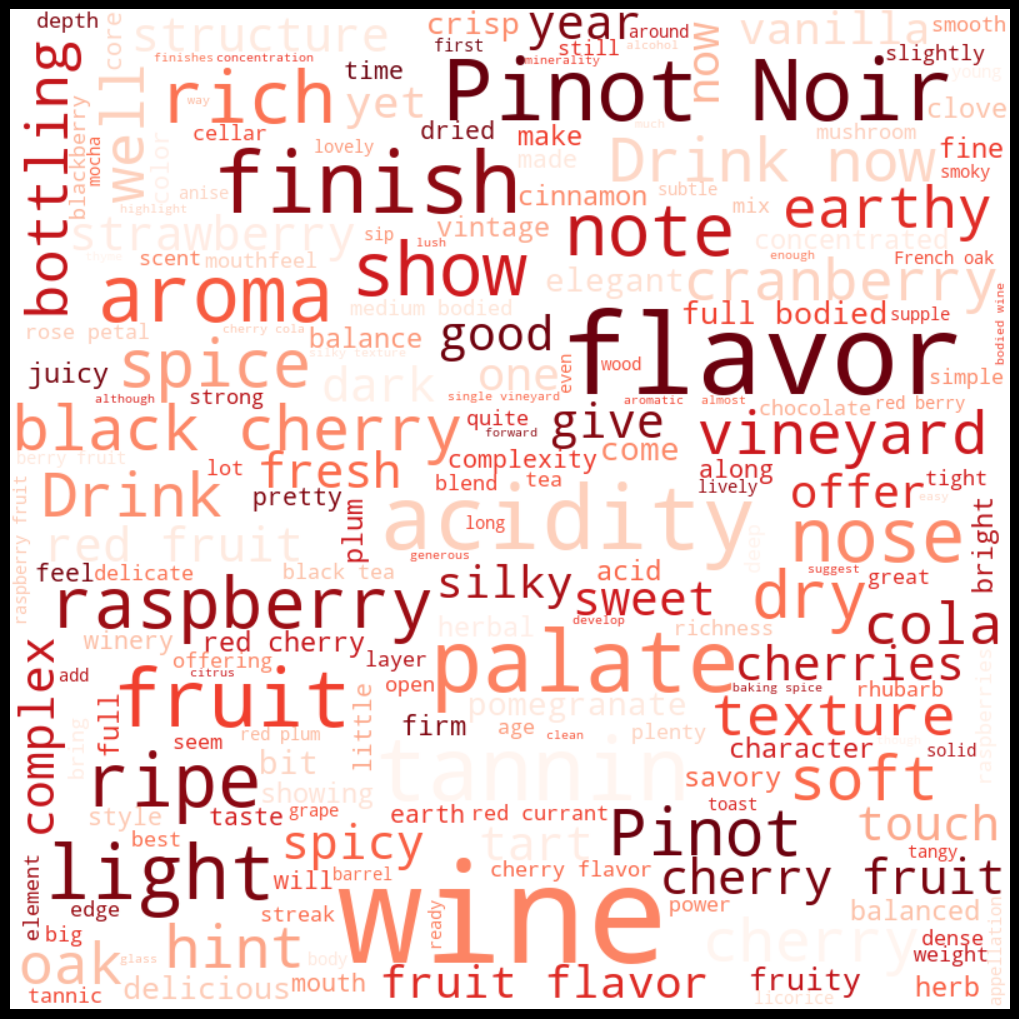

In [426]:
#  Pinot
word_cloud_pinot = word_cloud(text_pinot)

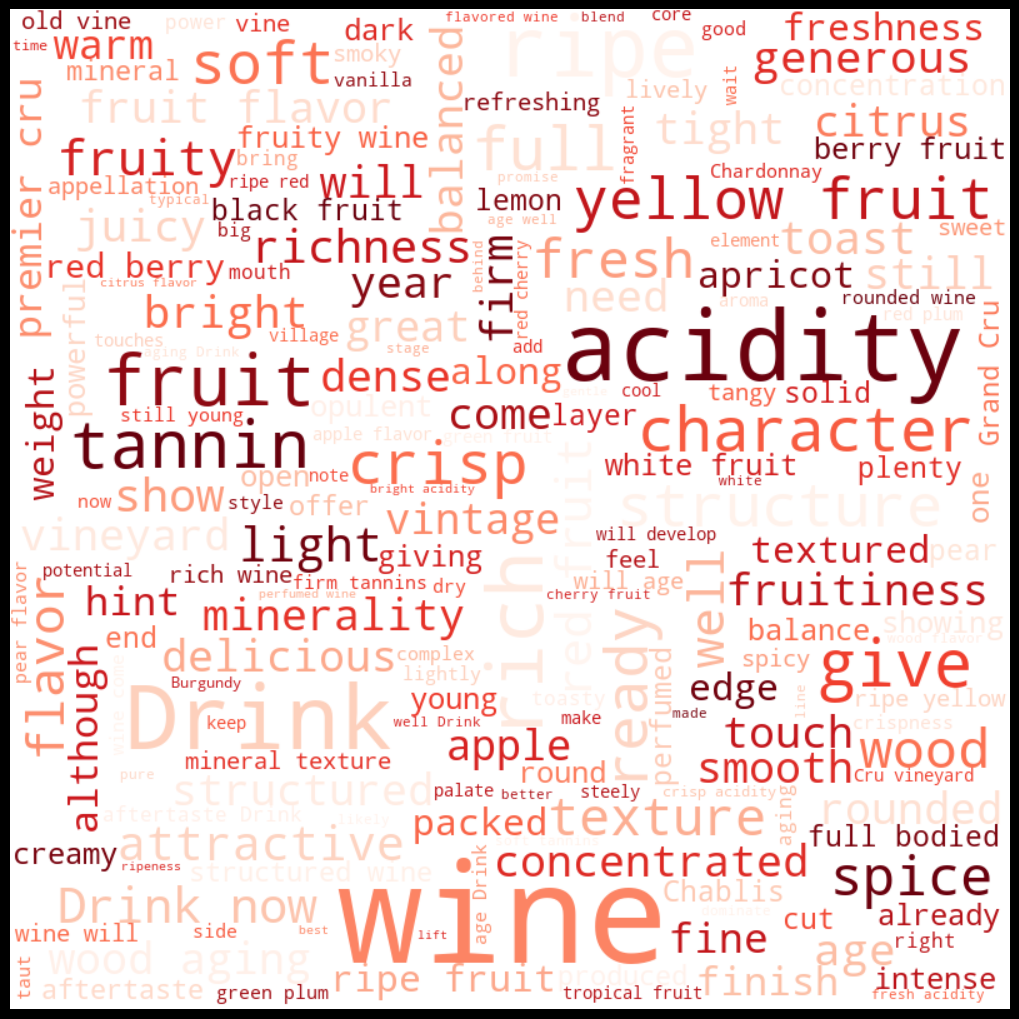

In [427]:
#  Burgundy
word_cloud_pinot = word_cloud(text_burgundy)

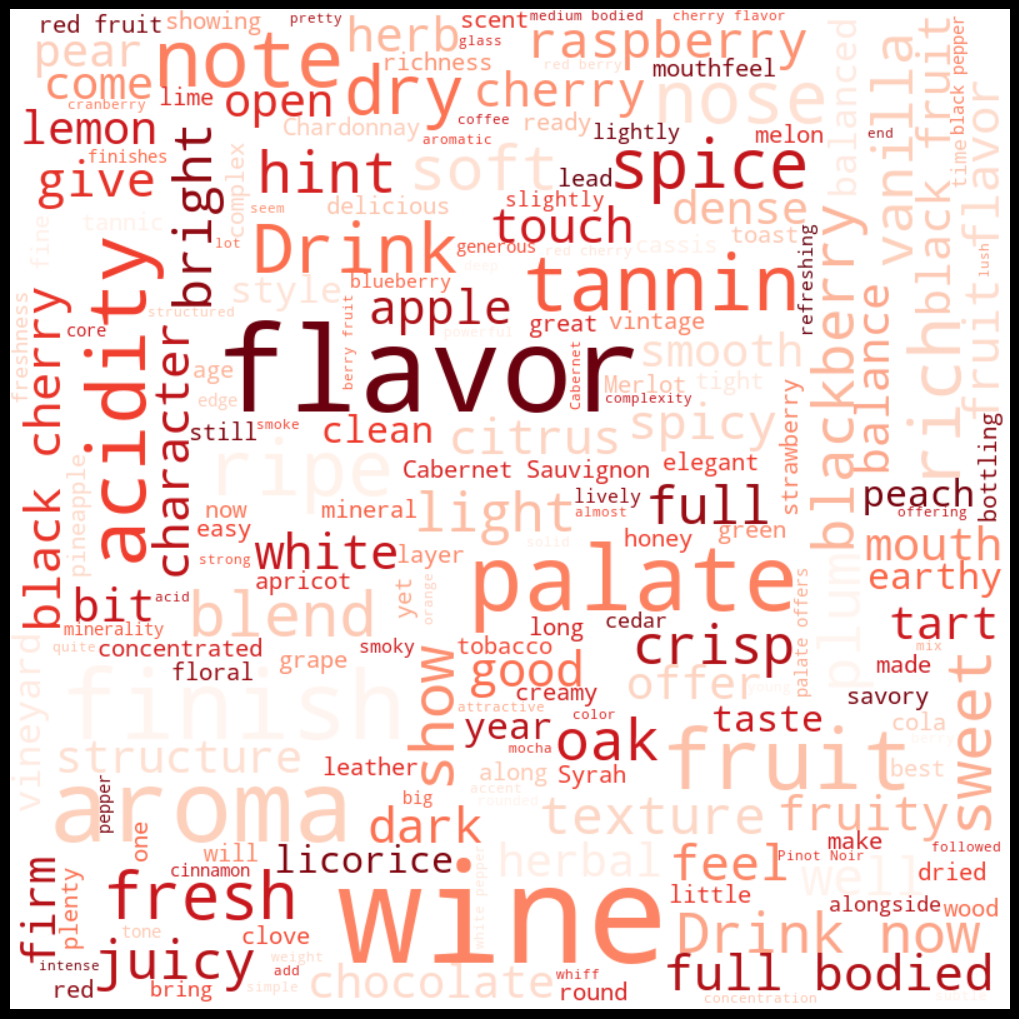

In [428]:
# Global
word_cloud_pinot = word_cloud(text_global)

# Framework: Business Intelligence



## Comparative analysis
The objective here will be to compare each of the client's wines to its competitors on the market. For example, compare the prices for French wines, then more and more precisely, Burgundy wines since our client is in Burgundy, then Burgundy Pinot Noir of the same year. Do not hesitate to be original in the presentation and the dataviz used. Use all the Business Intelligence functionalities in a dashboard to help the client to compare himself (tooltips, filters, etc...).

## Value proposition
With the dashboard you provided, the customer has a clear idea of his competitors. Make him a price proposal according to his positioning (for example: 'if you want to position yourself on the top of the range, the 25% most expensive of your competitors are at this price, we advise you to align yourself with this price').

## Aesthetic quality of the dashboard
Try to keep a critical and visual eye on your dashboard. The form counts as much as the content for the client who is not a data analyst. So think about 'selling' your analysis. For example, with colors inspired by the wine industry, original dataviz, etc...


In [429]:
domine_variety = df_domaine['variety'].unique()

years_domine = df_domaine['year'].unique()

df_domaine_min_points = df_domaine['points'].min()
df_domaine_max_points = df_domaine['points'].max()

df_domaine_mean_points = (df_domaine_min_points + df_domaine_max_points)/2


print(f"The Domaine des Croix wines rank between {df_domaine_min_points} and {df_domaine_max_points} points, the mean is {df_domaine_mean_points}")

The Domaine des Croix wines rank between 90 and 95 points, the mean is 92.5


In [430]:
df_domaine_price_analisis = df_domaine.groupby(['year', 'variety'])[['price', 'points']].mean().reset_index()
df_domaine_price_analisis

,year,variety,price,points
0,2014,Chardonnay,NaN,95.00
1,2014,Pinot Noir,NaN,92.00
2,2015,Pinot Noir,NaN,90.00
3,2016,Pinot Noir,NaN,93.00
4,2017,Pinot Noir,NaN,94.00
5,2018,Pinot Noir,NaN,93.25
6,2019,Pinot Noir,NaN,92.00


In [431]:
df_global_price_analisis = (df_global[(df_global['country'] == 'France')
                      & (df_global['province'] == 'Burgundy')
                      & (df_global['year'].isin(years_domine))
                      & (df_global['variety'].isin(domine_variety))
                      ])

# Choose price range
df_global_price_analisis['decile_rank_by_price'] = pd.qcut(df_global_price_analisis['price'], 10,labels = False)

check_prices = df_global_price_analisis.groupby('decile_rank_by_price')[['price', 'points']].mean().reset_index()

/var/folders/ch/vbngt5w11_57bxmvvnk7pw380000gn/T/ipykernel_85710/363732968.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [432]:
check_prices

,decile_rank_by_price,price,points
0,0,18.303371,84.876404
1,1,24.143750,86.568750
2,2,28.865248,87.624113
3,3,34.360759,88.715190
4,4,40.674699,90.006024
5,5,48.132911,90.392405
6,6,56.433566,90.643357
7,7,67.101266,91.803797
8,8,87.406897,92.365517
9,9,191.802548,93.949045


In [433]:
# I'll keep wines on the 8th deciles since their poits mean is the closest to the client points mean and not to be a luxury wine
df_global_price_analisis = df_global_price_analisis[df_global_price_analisis['decile_rank_by_price'].between(8, 9, inclusive='left')]
df_global_price_analisis.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,decile_rank_by_price
2227,France,"At this stage, the wine is all dark structure ...",Petite Chapelle Premier Cru,94,82.0,Burgundy,Gevrey-Chambertin,NaN,Roger Voss,@vossroger,Louis Jadot 2015 Petite Chapelle Premier Cru ...,Pinot Noir,Louis Jadot,2015,8
3072,France,The aromas of smoky new wood follow through to...,Clos des Mouches Premier Cru,94,91.0,Burgundy,Beaune,NaN,Roger Voss,@vossroger,Joseph Drouhin 2014 Clos des Mouches Premier C...,Pinot Noir,Joseph Drouhin,2014,8
3964,France,There is a voluptuous edge to this generous wi...,Les Damodes Premier Cru,90,88.0,Burgundy,Nuits-St.-Georges,NaN,Roger Voss,@vossroger,Louis Latour 2014 Les Damodes Premier Cru (Nu...,Pinot Noir,Louis Latour,2014,8
5230,France,"Still young and firm, this wine gives indicati...",NaN,91,77.0,Burgundy,Corton Les Renardes,NaN,Roger Voss,@vossroger,Domaine Maillard 2017 Corton Les Renardes,Pinot Noir,Domaine Maillard,2017,8
5753,France,"Three barrels were made of this structured, ta...",Les Beaux Monts Premier Cru,92,100.0,Burgundy,Vosne-Romanée,NaN,Roger Voss,@vossroger,Louis Latour 2018 Les Beaux Monts Premier Cru ...,Pinot Noir,Louis Latour,2018,8


In [434]:
# df_global_price_analisis = df_global_price_analisis.groupby(['year', 'variety'])[['price', 'points']].mean().reset_index()

df_global_price_analisis['price_max'] = df_global_price_analisis['price']

df_global_price_analisis['price_mean'] = df_global_price_analisis['price']

df_global_price_analisis = df_global_price_analisis.groupby(['year', 'variety'])[['price', 'price_max', 'price_mean', 'points']].agg({'price': 'min', 'price_max': 'max', 'price_mean': 'mean', 'points' : 'mean'}).reset_index()

df_global_price_analisis = df_global_price_analisis.rename(columns={"price": "price_min"})

df_global_price_analisis['year'] = df_global_price_analisis['year'].astype('int32')

df_global_price_analisis = df_global_price_analisis[~((df_global_price_analisis['year'] > 2014) & ~(df_global_price_analisis['variety'] == 'Pinot Noir'))]

df_global_price_analisis

,year,variety,price_min,price_max,price_mean,points
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364
3,2015,Pinot Noir,82.0,102.0,92.133333,91.533333
5,2016,Pinot Noir,76.0,104.0,86.428571,91.785714
7,2017,Pinot Noir,76.0,102.0,85.913043,92.521739
9,2018,Pinot Noir,79.0,100.0,87.875000,92.500000
11,2019,Pinot Noir,78.0,92.0,84.000000,93.500000


In [435]:
df_domaine_price_analisis

,year,variety,price,points
0,2014,Chardonnay,NaN,95.00
1,2014,Pinot Noir,NaN,92.00
2,2015,Pinot Noir,NaN,90.00
3,2016,Pinot Noir,NaN,93.00
4,2017,Pinot Noir,NaN,94.00
5,2018,Pinot Noir,NaN,93.25
6,2019,Pinot Noir,NaN,92.00


In [436]:
df_price_analisis = df_global_price_analisis.merge(df_domaine_price_analisis, how='inner', on=['year',	'variety'], suffixes=('_global', '_domaine'), copy=True, indicator=False, validate=None)
df_price_analisis =  df_price_analisis.rename(columns={'price':'price_sugested'})
df_price_analisis

,year,variety,price_min,price_max,price_mean,points_global,price_sugested,points_domaine
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667,NaN,95.00
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364,NaN,92.00
2,2015,Pinot Noir,82.0,102.0,92.133333,91.533333,NaN,90.00
3,2016,Pinot Noir,76.0,104.0,86.428571,91.785714,NaN,93.00
4,2017,Pinot Noir,76.0,102.0,85.913043,92.521739,NaN,94.00
5,2018,Pinot Noir,79.0,100.0,87.875000,92.500000,NaN,93.25
6,2019,Pinot Noir,78.0,92.0,84.000000,93.500000,NaN,92.00


In [437]:
def sugest_price(my_df):
  for i in range(len(my_df)):
    if my_df['points_global'].iloc[i] > my_df['points_domaine'].iloc[i]:
      my_df['price_sugested'].iloc[i] = math.floor(my_df['price_mean'].iloc[i])
    else:
      my_df['price_sugested'].iloc[i] = math.ceil(my_df['price_mean'].iloc[i])
  return my_df

In [438]:
price_suggestion = sugest_price(df_price_analisis)

/var/folders/ch/vbngt5w11_57bxmvvnk7pw380000gn/T/ipykernel_85710/3487544106.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ch/vbngt5w11_57bxmvvnk7pw380000gn/T/ipykernel_85710/3487544106.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [439]:
price_suggestion

,year,variety,price_min,price_max,price_mean,points_global,price_sugested,points_domaine
0,2014,Chardonnay,82.0,100.0,91.666667,91.666667,92.0,95.00
1,2014,Pinot Noir,78.0,104.0,91.181818,90.636364,92.0,92.00
2,2015,Pinot Noir,82.0,102.0,92.133333,91.533333,92.0,90.00
3,2016,Pinot Noir,76.0,104.0,86.428571,91.785714,87.0,93.00
4,2017,Pinot Noir,76.0,102.0,85.913043,92.521739,86.0,94.00
5,2018,Pinot Noir,79.0,100.0,87.875000,92.500000,88.0,93.25
6,2019,Pinot Noir,78.0,92.0,84.000000,93.500000,84.0,92.00
